In [3]:
import ROOT as r
import numpy as np
import os
import matplotlib.pyplot as plt

dataDir = '/mnt/c/users/llave/Documents/CMS/data/'
fname = 'orig/images_v3_DYJets50.root'
fin = r.TFile(dataDir + fname)
tree = fin.Get('trackImageProducer/tree')

In [5]:
import math

e_events,bkg_events = [],[]
res_eta = 20
res_phi = 20

#eta and phi upper and lower bounds
eta_ub,eta_lb = 3,-3
phi_ub,phi_lb = math.pi,-math.pi

def convert_eta(eta):
    return int(round(((res_eta-1)/(eta_ub-eta_lb))*(eta-eta_lb)))

def convert_phi(phi):
    return int(round(((res_phi-1)/(phi_ub-phi_lb))*(phi-phi_lb)))

#overlap (EE,EB), (CSC,DT,RPC)
def type_to_channel(hittype):
    #none
    if(hittype == 0 ): return 0
    #(EE,EB)
    if(hittype == 1 or hittype == 2): return 1
    #ES
    if(hittype == 3): return 2
    #HCAL
    if(hittype == 4): return 3
    #(CSC,DT,RPC)
    if(hittype == 5 or hittype ==6 or hittype == 7): return 4

for event in tree:
               
    matrix = np.zeros([res_eta,res_phi,5])
    
    for iTrack in range(len(event.track_eta)):
        
        #truth electrons
        if(abs(event.track_genMatchedID[iTrack])!=11): continue

        #electron events where the RECO failed 
        if(event.track_deltaRToClosestElectron[iTrack] < 0.15 and event.track_deltaRToClosestElectron[iTrack] > -0.1): continue
            
        scale = max(event.recHits_energy)
        
        for iHit in range(len(event.recHits_eta)):

            dEta = event.track_eta[iTrack] - event.recHits_eta[iHit]
            dPhi = event.track_phi[iTrack] - event.recHits_phi[iHit]
            # branch cut [-pi, pi)
            if abs(dPhi) > math.pi:
                dPhi -= round(dPhi / (2. * math.pi)) * 2. * math.pi

            if(dPhi > phi_ub or dPhi < phi_lb): continue
            if(dEta > eta_ub or dEta < eta_lb): continue

            dEta = convert_eta(dEta)
            dPhi = convert_phi(dPhi)
            channel = type_to_channel(event.recHits_detType[iHit])
            
            matrix[dEta,dPhi,channel] = event.recHits_energy[iHit]/scale
        
        if(abs(event.track_genMatchedDR[iTrack]) < 0.1): e_events.append(matrix)
        else: bkg_events.append(matrix)

KeyboardInterrupt: 

In [15]:
print(len(e_events),len(bkg_events))
np.save(dataDir+'e_DYJets50V3_norm_20x20', e_events)
np.save(dataDir+'bkg_DYJets50V3_norm_20x20', bkg_events)

98 1064


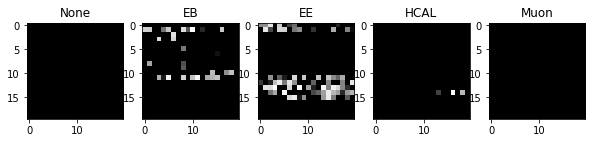

In [8]:
def plot_event(x):
    
    fig, axs = plt.subplots(1,5,figsize=(10,10))
    
    for i in range(5):
        axs[i].imshow(x[i,:,:],cmap='gray')
    
    axs[0].set_title("None")
    axs[1].set_title("EE - EB")
    axs[2].set_title("ES")
    axs[3].set_title("HCAL")
    axs[4].set_title("CSC - DT - RPC")
    
    plt.show()

plot_event(e_events[0])